In [ ]:
# Windowsでは動かない
!conda install numpy matplotlib pytorch torchvision tensorboad -c pytorch -c conda-forge -y

In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # step1 データの作成

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"Using {device}")

Using mps


## Generate data

In [4]:
N = 1024
x_data = np.zeros((N,2))
y_data = np.zeros((N,1))

np.random.seed(42)

for i in range(N):
    r = np.random.uniform(0,2)
    th = np.random.uniform(0,2*np.pi)
    x_data[i] = r*np.cos(th), r*np.sin(th)
    if r > 1:
        y_data[i] = 1

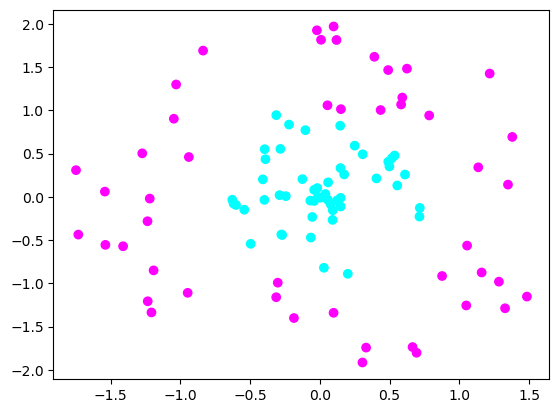

In [5]:
plt.scatter(x_data[:100,0],x_data[:100,1],c=y_data[:100],cmap="cool")

In [27]:
# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x_data,dtype=torch.float32,device=device)
y_tensor = torch.tensor(y_data,dtype=torch.float32,device=device)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

# Create a DataLoader from the TensorDataset
N_batch = 256
dataloader = DataLoader(dataset, batch_size=N_batch, shuffle=True)

# Wrriten by codegpt extension

高速化のためのDataLoaderの設定について（読んだだけ）

https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

## Build models

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self,width,depth):
        super(NeuralNetwork, self).__init__()
        self.depth = depth
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # first hidden layer
        self.dense1 = nn.Linear(2,width,False,) # 2 * width weights
        # deep layer
        self.seq = nn.Linear(width,width,False,) # width * width weights
        # output layer for binary logistic regression
        self.blr = nn.Sequential(
            nn.Linear(width,1,False,), # width weights
            nn.Sigmoid()
        )

    def forward(self, x):
        l = self.depth
        for i in range(l):
            if i == 0:
                x = self.dense1(x)
                x = self.relu(x)
            else:
                x = self.seq(x)
                x = self.tanh(x)
        return self.blr(x)

In [ ]:
# Check that relevant parameters are only updated.
model = NeuralNetwork(width=2,depth=1)

# print all model parameters before training
for name, param in model.named_parameters():
    print(f'{name}: {param}')

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(params=model.parameters())
model.train(True)
for i, data in enumerate(dataloader): # N//N_batch loops 
    optimizer.zero_grad()
    inputs, labels = data
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

# print all model parameters after training
for name, param in model.named_parameters():
    print(f'{name}: {param}')


In [28]:
models=dict()
models["base"] = NeuralNetwork(width=4,depth=1) # 12 weights

models["2-hidden"] = NeuralNetwork(width=4, depth=2) # 28 weights
models["3-hidden"] = NeuralNetwork(width=4, depth=3) # 44 weights
models["4-hidden"] = NeuralNetwork(width=4, depth=4) # 60 weights

models["width-16"] = NeuralNetwork(width=16,depth=1) # 48 weights
models["width-64"] = NeuralNetwork(width=64,depth=1) # 192 weights
models["width-256"] = NeuralNetwork(width=256,depth=1) # 768 weights

loss_fn = nn.BCELoss()

# debug
# loss_fn(models["base"](torch.rand(1,2)), torch.tensor([0]))

## Training

In [10]:
from torch.utils.tensorboard import SummaryWriter

In [29]:
N_epoch = 200

Writer =SummaryWriter("runs/Jun14-17-42-12_LAB")

for key, model in models.items():
    model.to(device) # move model on gpu BEFORE initialize optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    for epoch in range(N_epoch):
        model.train(True)
        epoch_loss = 0
        for i, data in enumerate(dataloader): # N//N_batch loops 
            optimizer.zero_grad()
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() / (N//N_batch)
        Writer.add_scalar(f"Loss/{key}", epoch_loss,epoch)
        # verbose
        if epoch%100 == 99:
            print(f"model {key}| epochs: {epoch+1} | loss: {epoch_loss}")
Writer.close()

model base| epochs: 100 | loss: 0.5839691609144211
model base| epochs: 200 | loss: 0.5839418321847916
model 2-hidden| epochs: 100 | loss: 0.5868202894926071
model 2-hidden| epochs: 200 | loss: 0.5855967402458191
model 3-hidden| epochs: 100 | loss: 0.5868646949529648
model 3-hidden| epochs: 200 | loss: 0.585680291056633
model 4-hidden| epochs: 100 | loss: 0.5879892259836197
model 4-hidden| epochs: 200 | loss: 0.5866930335760117
model width-16| epochs: 100 | loss: 0.5833167880773544
model width-16| epochs: 200 | loss: 0.583414152264595
model width-64| epochs: 100 | loss: 0.5825740098953247
model width-64| epochs: 200 | loss: 0.5827241837978363
model width-256| epochs: 100 | loss: 0.5841883271932602
model width-256| epochs: 200 | loss: 0.5824679136276245


## Visualize output of trained models

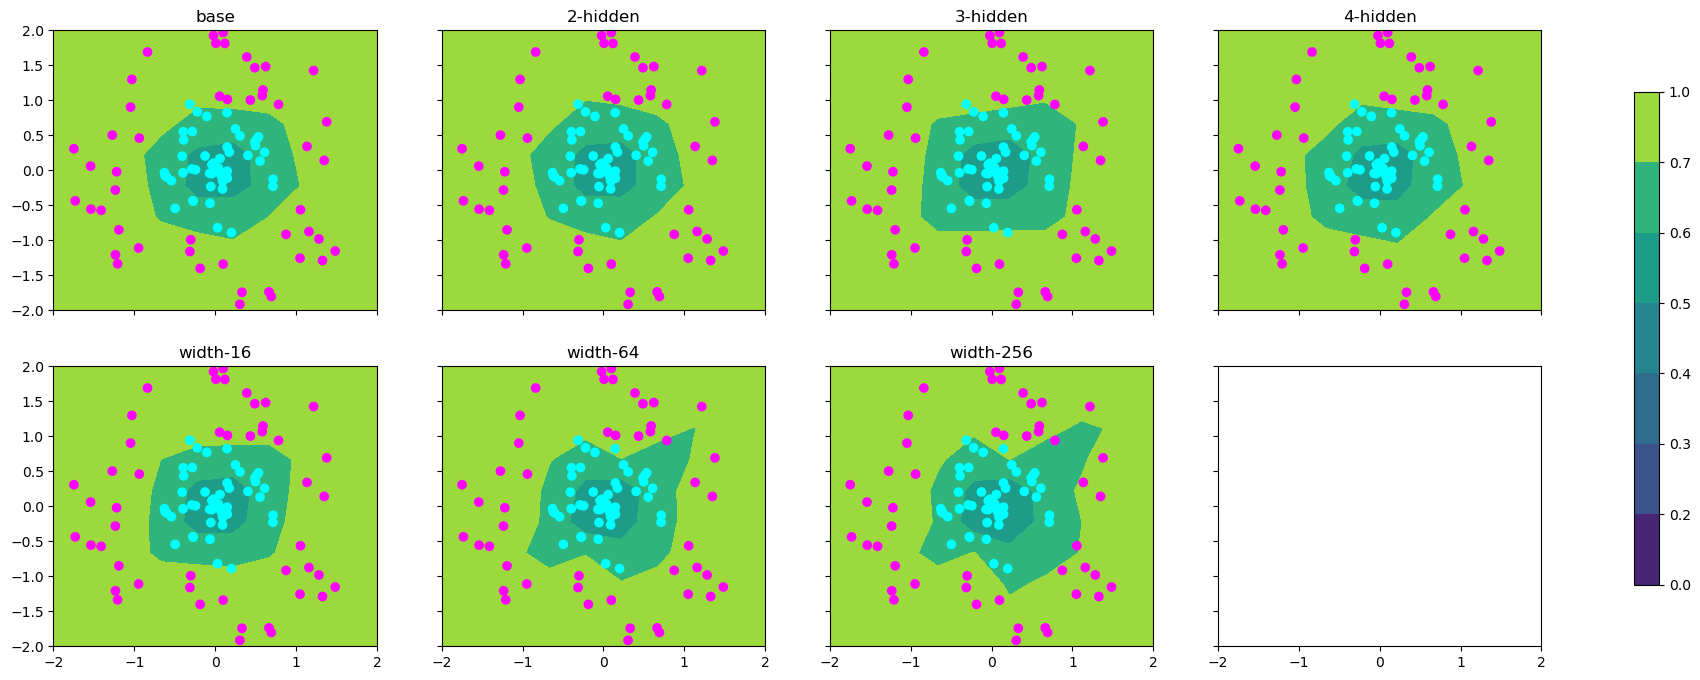

In [45]:
mesh = 10
x = np.linspace(-2,2,mesh,dtype=np.float32)
y = np.linspace(-2,2,mesh,dtype=np.float32)

X, Y = np.meshgrid(x, y)

Z = np.zeros((mesh,mesh))

fig, axs = plt.subplots(2,4,sharex=True,sharey=True)

fig.set_figwidth(24)
fig.set_figheight(8)

n = 0

levels = np.array([0.,0.2,0.3,0.4,0.5,0.6,0.7,1])

for (name, model), ax in zip(models.items(),axs.flat):
    for i in range(mesh):
        for j in range(mesh):
            x1, x2 = X[i,j], Y[i,j]
            Z[i,j] = model(torch.tensor([x1,x2],device=device))

    cs = ax.contourf(X, Y, Z, levels=levels,)
    ax.scatter(x_data[:100,0],x_data[:100,1],c=y_data[:100],cmap="cool")
    ax.set_title(name)
    n += 1
fig.colorbar(cs,ax=axs[:],location="right",shrink=0.8)

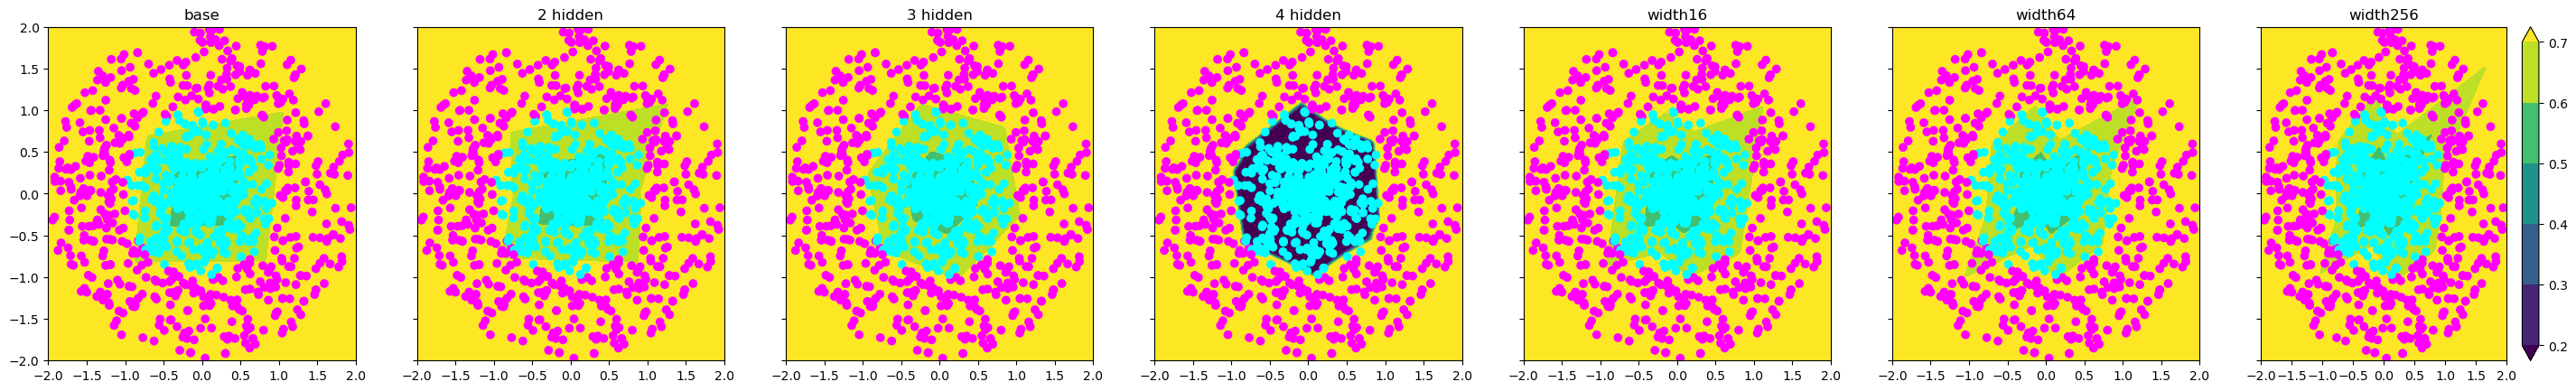

In [37]:
# plot with all data
for ax in axs.flat:
    ax.scatter(x_data[:1000,0],x_data[:1000,1],c=y_data[:1000],cmap="cool")
display(fig)